In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

## Read in dataframes

In [3]:
# import dataframes to construct network model
personalities = pd.read_pickle('personalities.pkl')
favorites = pd.read_pickle('favorites_cleaned_lemma.pkl')
profiles = pd.read_pickle('profiles.pkl')
topics = pd.read_pickle('model_data.pkl')

In [4]:
personalities.head(1)

,user_id,all_tweets,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional range
0,2649540547,"@nbcsnl ok this is legendary, 𝗙𝗹𝗶𝗽𝗽𝗲𝗱 𝘁𝗵𝗲 𝘀𝘄𝗶𝘁...",0.730236,0.334933,0.411628,0.106015,0.552724


In [5]:
favorites.head(1)

,favorited_by_id,id,created_at,screen_name,user_id,in_reply_to_status_id,in_reply_to_screen_name,in_reply_to_user_id,favorite_count,retweet_count,text
0,2649540547,1236533635290890240,Sun Mar 08 06:06:06 +0000 2020,AOC,138203134,1.236524e+18,nbcsnl,28221296.0,115728,3550,ok this is legendary


In [6]:
profiles.head(1)

,user_id,screen_name,followers_count,friends_count,favourites_count,statuses_count,follower_ids,friend_ids
0,2649540547,baka_brooks,234,257,4931,218,"[1094750013304029187, 1235337664083222528, 133...","[1235337664083222528, 14372486, 11598303501027..."


In [7]:
topics.head(1)

,id,created_at,screen_name,user_id,in_reply_to_status_id,in_reply_to_screen_name,in_reply_to_user_id,favorite_count,retweet_count,text,...,vader_neu,vader_compound,clusters,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,1236533635290890240,Sun Mar 08 06:06:06 +0000 2020,AOC,138203134,1.236524e+18,nbcsnl,28221296.0,115728,3550,ok this is legendary,...,0.577,0.296,2,0.00031,0.0008,0.000266,0.000556,0.000949,0.00009,0.000194


Before merging the dataframes into a single dataset, I'd like to take a look another look at the topics & sentiment data to get a sense for how to attribute tweet-level data to each user.

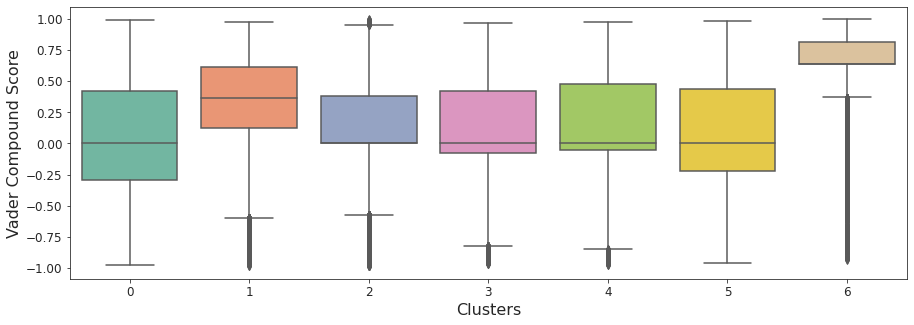

In [12]:
plt.figure(figsize=(15,5))
sns.set_palette('Set2')
sns.set_style('ticks')

sns.boxplot(x='clusters', y='vader_compound', data=topics)
plt.tick_params(labelsize=12)
plt.xlabel('Clusters', fontsize=16)
plt.ylabel('Vader Compound Score', fontsize=16)
plt.savefig('sentiment_box.png', transparent=True);

## Clean and merge dataframes

### Merge user profile attributes with personality profiles

In [7]:
# separate friend and follower ids into separate dataframe to be added after aggregation
followers = profiles.loc[:, ['user_id', 'follower_ids', 'friend_ids']]
profiles = profiles.drop(columns=['follower_ids', 'friend_ids'])

In [94]:
# merge profiles and personalities
users = profiles.merge(personalities.drop(columns='all_tweets'), on='user_id')
users = users.drop_duplicates('user_id', keep='first')
print(users.shape)
users.head()

(179, 11)


,user_id,screen_name,followers_count,friends_count,favourites_count,statuses_count,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional range
0,2649540547,baka_brooks,234,257,4931,218,0.730236,0.334933,0.411628,0.106015,0.552724
3,1094750013304029187,Kwammentary,534,1748,698,210,0.906036,0.550105,0.648426,0.297694,0.500949
4,1235337664083222528,D1_data,5,64,7,1,0.708852,0.768717,0.294999,0.154030,0.112169
5,1333491954,lolegra,169,346,2614,2647,0.518856,0.069776,0.637403,0.241616,0.757079
6,1219308741369253894,stealsdeals12,93,1150,1130,878,0.466320,0.706029,0.187577,0.058168,0.317718


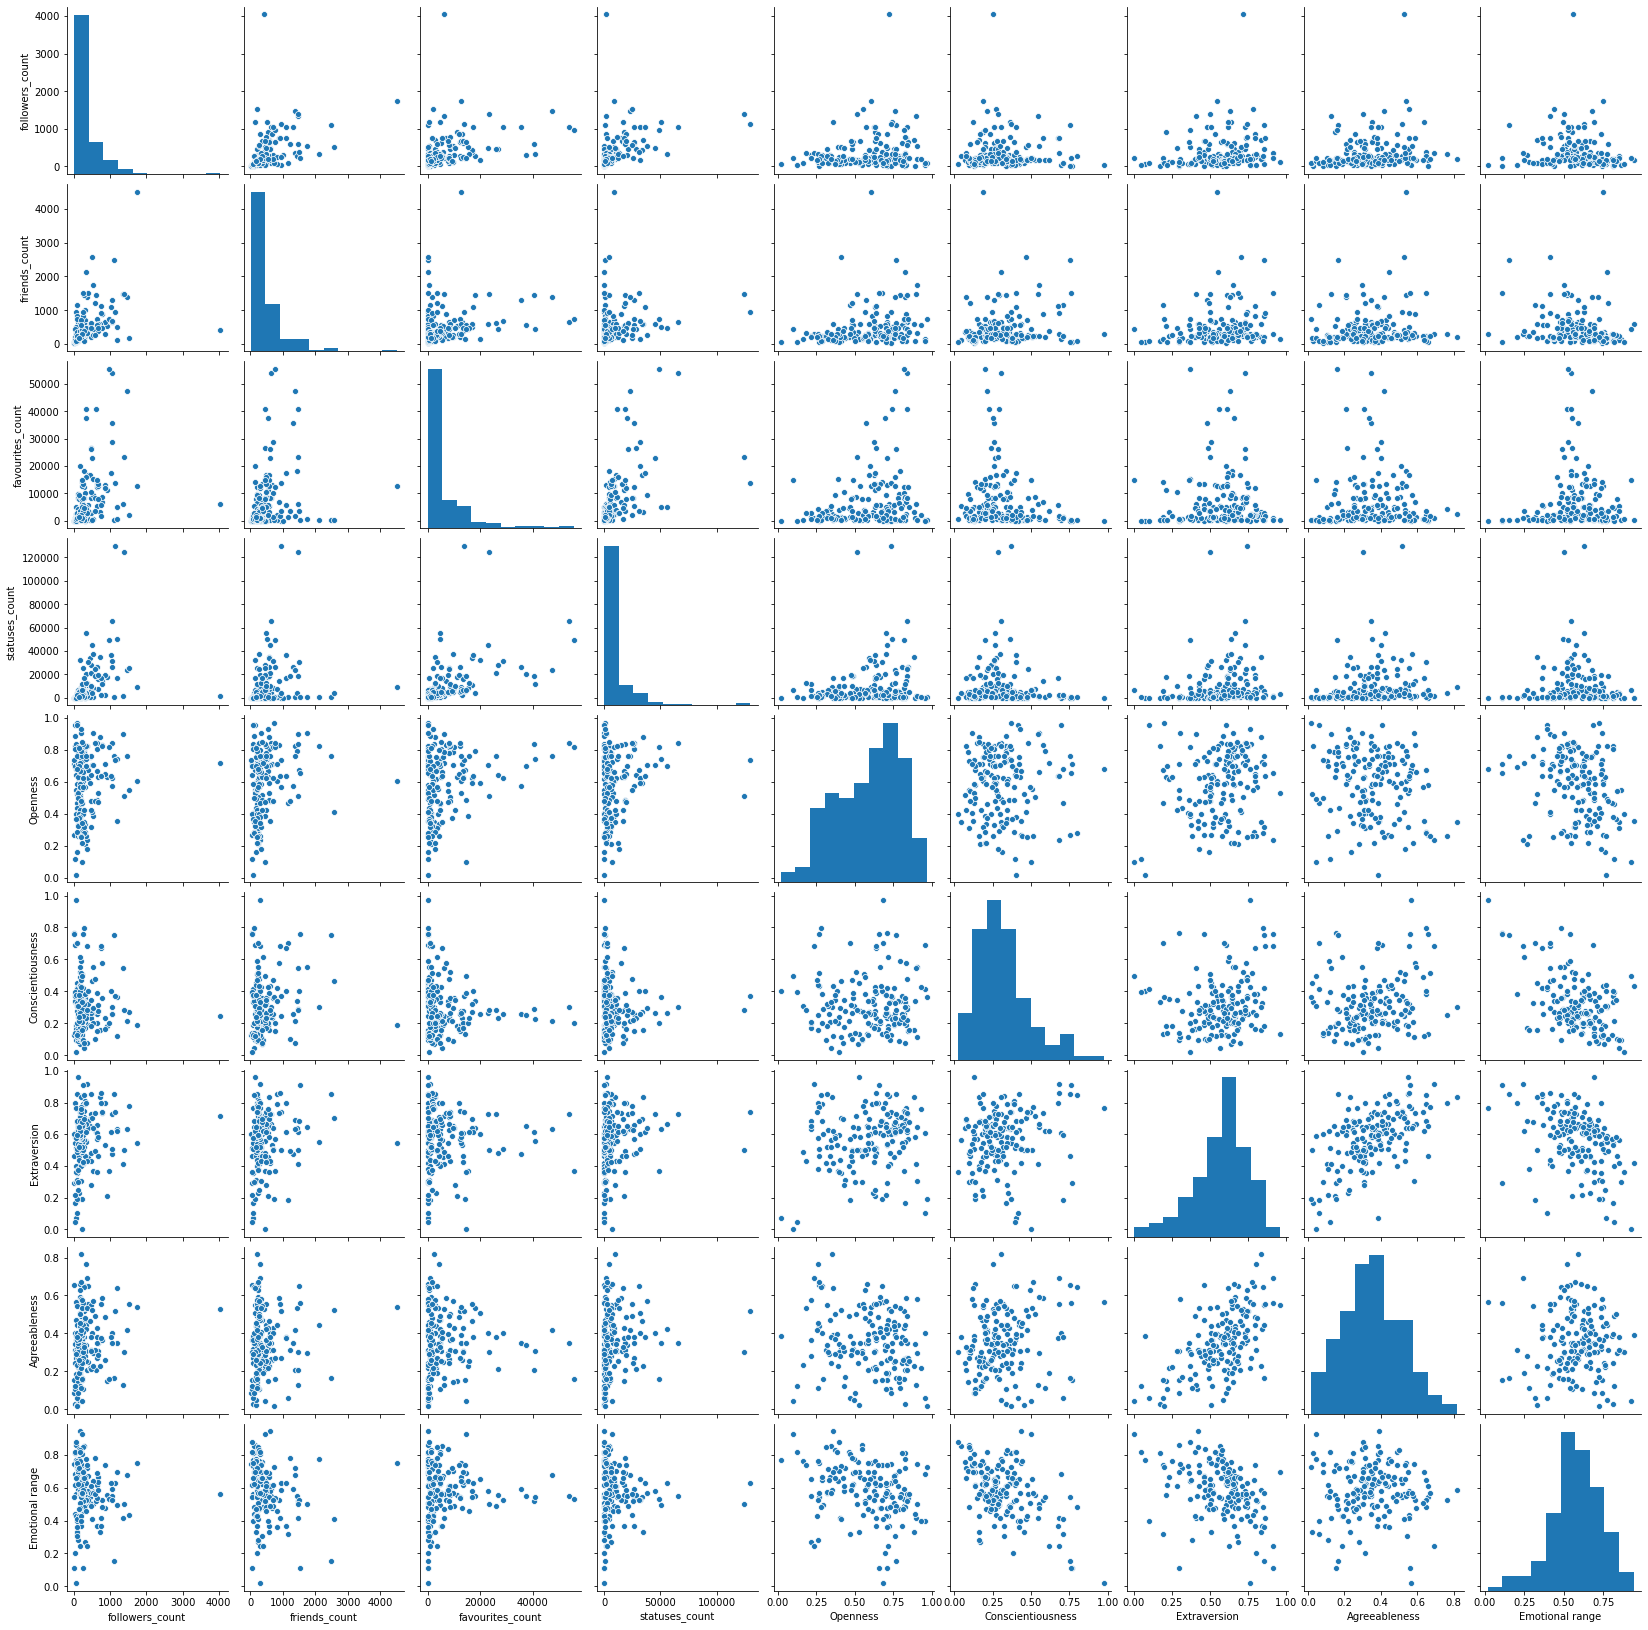

In [96]:
sns.pairplot(users.iloc[:, 2:]);

As I suspected, the `followers_count`, `friends_count`, `favourites_count`, and `statuses_count` features are right skewed. I will scale these features and re-align with the dataframe to allow for cleaner modeling of the data.

In [87]:
scaler = StandardScaler()

In [99]:
scaled_attrs = scaler.fit_transform(users.loc[:, ['followers_count', 'friends_count', 'favourites_count', 'statuses_count']])
scaled_attrs[:10]

array([[-0.26299706, -0.40370641, -0.13598679, -0.52017749],
       [ 0.42954166,  2.4048539 , -0.56809406, -0.52064404],
       [-0.79163495, -0.7672558 , -0.63863177, -0.53283259],
       [-0.41304712, -0.23605928, -0.37250759, -0.37852205],
       [-0.58849026,  1.2784159 , -0.52399523, -0.48168734],
       [ 1.31368276,  0.14067584,  0.50232335,  0.51474117],
       [-0.76624186, -0.74088434, -0.62719874, -0.53049985],
       [-0.70622184, -0.59207397, -0.62403424, -0.52665084],
       [ 1.71997215,  3.80065752, -0.61933854, -0.50320683],
       [ 1.91157453,  0.06156146, -0.15089056,  2.41265581]])

In [113]:
# replace original attributes with scaled data
users_scaled = users.copy()

cols = ['followers_count', 'friends_count', 'favourites_count', 'statuses_count']
for idx, col in enumerate(cols):
    users_scaled[col] = scaled_attrs[:, idx]
    
users_scaled.head()

,user_id,screen_name,followers_count,friends_count,favourites_count,statuses_count,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional range
0,2649540547,baka_brooks,-0.262997,-0.403706,-0.135987,-0.520177,0.730236,0.334933,0.411628,0.106015,0.552724
3,1094750013304029187,Kwammentary,0.429542,2.404854,-0.568094,-0.520644,0.906036,0.550105,0.648426,0.297694,0.500949
4,1235337664083222528,D1_data,-0.791635,-0.767256,-0.638632,-0.532833,0.708852,0.768717,0.294999,0.154030,0.112169
5,1333491954,lolegra,-0.413047,-0.236059,-0.372508,-0.378522,0.518856,0.069776,0.637403,0.241616,0.757079
6,1219308741369253894,stealsdeals12,-0.588490,1.278416,-0.523995,-0.481687,0.466320,0.706029,0.187577,0.058168,0.317718


### Merge `favorites` and `topics` dataframes to attribute user_ids to sentiment, topics, and clusters

In [9]:
# concatenate favorites and topics, keeping only 'favorited_by_id' from 
# the original dataframe
tweets = pd.concat([favorites.loc[:, 'favorited_by_id'], topics], axis=1)

# drop unneeded columns
tweets = tweets.drop(columns=['id', 'created_at', 'screen_name', 'user_id', 'in_reply_to_status_id',
                             'in_reply_to_screen_name', 'in_reply_to_user_id', 'text', 'type', 
                             'favorite_count', 'retweet_count'])
print(tweets.shape)
tweets.head()

(547463, 15)


,favorited_by_id,textblob_polarity,textblob_subjectivity,vader_neg,vader_pos,vader_neu,vader_compound,clusters,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,2649540547,0.750,0.750,0.000,0.423,0.577,0.2960,2,0.000310,0.000800,0.000266,0.000556,0.000949,0.000090,0.000194
1,2649540547,0.000,0.000,0.000,0.000,1.000,0.0000,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2649540547,-0.075,0.825,0.096,0.220,0.683,0.4588,1,0.058949,0.000000,0.000000,0.003409,0.013943,0.092806,0.000899
3,2649540547,0.500,0.500,0.268,0.000,0.732,-0.6701,2,0.000236,0.000508,0.000718,0.000266,0.004143,0.000158,0.000368
4,2649540547,0.000,0.000,0.000,0.000,0.000,0.0000,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Ultimately I want to create a recommendation based on each unique user. The dataframe currently represents the sentiment polarity scores, cluster assignments via kmeans, and topic weights per document. To model this data, I will need to create aggregations to attribute each component to each unique user.

In [70]:
# find the average sentiment score per user per cluster - vader coumpound
avg_sentiment = tweets.groupby(['favorited_by_id', 'clusters'], as_index=False).vader_compound.mean()

# pivot columns
avg_sentiment_pivot = avg_sentiment.pivot_table(index='favorited_by_id', columns='clusters', values='vader_compound').reset_index().rename_axis(None, axis=1)

# rename columns
avg_sentiment_pivot.columns = ['user_id'] + ['polarity_cluster_' + str(num) for num in range(7)]
avg_sentiment_pivot.head()

,user_id,polarity_cluster_0,polarity_cluster_1,polarity_cluster_2,polarity_cluster_3,polarity_cluster_4,polarity_cluster_5,polarity_cluster_6
0,3840,0.112737,0.398482,0.187999,0.201818,0.222017,0.139913,0.683018
1,1300301,NaN,NaN,0.235120,NaN,NaN,NaN,NaN
2,15043664,0.143196,0.353876,0.090186,0.093165,0.145393,0.093893,0.604089
3,17790052,0.120400,0.110700,0.057933,0.187150,-0.066878,-0.089583,0.727800
4,18210249,0.077132,0.431636,0.171286,0.111314,0.211751,0.225514,0.630900


In [73]:
# aggregate the topic weights across documents per user
topic_weights = tweets.groupby('favorited_by_id', as_index=False).mean()

# select the topic weights
topic_weights = topic_weights.loc[:, ['favorited_by_id'] + ['topic_' + str(num) for num in range(7)]].rename(columns={'favorited_by_id': 'user_id'})
topic_weights.head()

,user_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,3840,0.002816,0.001711,0.004604,0.003548,0.009551,0.003871,0.003190
1,1300301,0.000066,0.000297,0.000599,0.000479,0.021437,0.000230,0.000390
2,15043664,0.004078,0.005008,0.003998,0.004637,0.010946,0.002853,0.002506
3,17790052,0.004045,0.006401,0.003713,0.006786,0.010579,0.003679,0.001989
4,18210249,0.002655,0.002320,0.004433,0.003029,0.011045,0.003382,0.003231


In [74]:
# calculate the number of tweets per user per cluster
clusters_count = tweets.groupby(['favorited_by_id', 'clusters'], as_index=False).topic_0.count().rename(columns={'topic_0': 'tweets_per_topic'})

# calculate the total number of tweets per user
tweets_count = tweets.groupby('favorited_by_id', as_index=False).topic_0.count().rename(columns={'topic_0': 'total_tweets'})

# merge the dataframes
tweets_agg = clusters_count.merge(tweets_count, on='favorited_by_id')

# calculate the distribution of tweets per user per cluster
tweets_agg['perc_of_tweets'] = tweets_agg['tweets_per_topic'] / tweets_agg['total_tweets']

# drop extra columns
tweets_agg = tweets_agg.drop(columns=['tweets_per_topic', 'total_tweets'])

# pivot columns
tweets_agg_pivot = tweets_agg.pivot_table(index='favorited_by_id', columns='clusters', values='perc_of_tweets').reset_index().rename_axis(None, axis=1)

# rename columns
tweets_agg_pivot.columns = ['user_id'] + ['perc_cluster_' + str(num) for num in range(7)]
tweets_agg_pivot.head()

,user_id,perc_cluster_0,perc_cluster_1,perc_cluster_2,perc_cluster_3,perc_cluster_4,perc_cluster_5,perc_cluster_6
0,3840,0.025900,0.039166,0.822489,0.028427,0.041377,0.015161,0.027479
1,1300301,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
2,15043664,0.015449,0.057934,0.788220,0.035404,0.033151,0.051497,0.018346
3,17790052,0.020270,0.060811,0.760135,0.054054,0.030405,0.060811,0.013514
4,18210249,0.023082,0.036577,0.833452,0.022727,0.036222,0.023082,0.024858


## Merge all attributes to user dataframe

In [114]:
# merge all dataframes to form full user-attribute dataframe for recommendation
rec_df = users_scaled.merge(tweets_agg_pivot, on='user_id').merge(avg_sentiment_pivot, on='user_id').merge(topic_weights, on='user_id')

# drop user_id column
rec_df = rec_df.drop(columns='user_id')
rec_df.head()

,screen_name,followers_count,friends_count,favourites_count,statuses_count,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional range,...,polarity_cluster_4,polarity_cluster_5,polarity_cluster_6,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,baka_brooks,-0.262997,-0.403706,-0.135987,-0.520177,0.730236,0.334933,0.411628,0.106015,0.552724,...,0.111010,0.246800,0.701033,0.003812,0.003851,0.005512,0.003765,0.011529,0.003104,0.002603
1,Kwammentary,0.429542,2.404854,-0.568094,-0.520644,0.906036,0.550105,0.648426,0.297694,0.500949,...,-0.092880,-0.154167,0.353436,0.003061,0.001680,0.003390,0.003421,0.010109,0.004580,0.001993
2,D1_data,-0.791635,-0.767256,-0.638632,-0.532833,0.708852,0.768717,0.294999,0.154030,0.112169,...,NaN,NaN,NaN,0.000062,0.001151,0.000587,0.000459,0.004842,0.000402,0.000189
3,lolegra,-0.413047,-0.236059,-0.372508,-0.378522,0.518856,0.069776,0.637403,0.241616,0.757079,...,0.076844,0.070533,0.665398,0.004961,0.006937,0.003897,0.004396,0.009471,0.003500,0.003333
4,stealsdeals12,-0.588490,1.278416,-0.523995,-0.481687,0.466320,0.706029,0.187577,0.058168,0.317718,...,0.246142,0.098733,0.691669,0.003849,0.002078,0.006285,0.005339,0.012632,0.004387,0.001792


There are quite a few nulls in the dataset. This is due to the observation previously discovered; there is a high skew inn the amount of activity of user accounts (i.e. someone who has like one million tweets and one that has liked two tweets). Nulls in this case represent a lack of activity, or low activity in relation to the user account. Because of this, it is safe to fill these values with zero.

In [115]:
# fill NaNs with zero
rec_df = rec_df.fillna(0)

# set screen_name as index
rec_df = rec_df.set_index('screen_name')
rec_df.head()

,followers_count,friends_count,favourites_count,statuses_count,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional range,perc_cluster_0,...,polarity_cluster_4,polarity_cluster_5,polarity_cluster_6,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
screen_name,,,,,,,,,,,,,,,,,,,,,
baka_brooks,-0.262997,-0.403706,-0.135987,-0.520177,0.730236,0.334933,0.411628,0.106015,0.552724,0.017500,...,0.111010,0.246800,0.701033,0.003812,0.003851,0.005512,0.003765,0.011529,0.003104,0.002603
Kwammentary,0.429542,2.404854,-0.568094,-0.520644,0.906036,0.550105,0.648426,0.297694,0.500949,0.027994,...,-0.092880,-0.154167,0.353436,0.003061,0.001680,0.003390,0.003421,0.010109,0.004580,0.001993
D1_data,-0.791635,-0.767256,-0.638632,-0.532833,0.708852,0.768717,0.294999,0.154030,0.112169,0.000000,...,0.000000,0.000000,0.000000,0.000062,0.001151,0.000587,0.000459,0.004842,0.000402,0.000189
lolegra,-0.413047,-0.236059,-0.372508,-0.378522,0.518856,0.069776,0.637403,0.241616,0.757079,0.016129,...,0.076844,0.070533,0.665398,0.004961,0.006937,0.003897,0.004396,0.009471,0.003500,0.003333
stealsdeals12,-0.588490,1.278416,-0.523995,-0.481687,0.466320,0.706029,0.187577,0.058168,0.317718,0.023339,...,0.246142,0.098733,0.691669,0.003849,0.002078,0.006285,0.005339,0.012632,0.004387,0.001792


## Create recommender system

In [116]:
# calculate cosine distances using feature set
dists = cosine_similarity(rec_df)

In [118]:
# convert cosine distances to a dataframe
dists = pd.DataFrame(dists, columns=rec_df.index)
dists.index = dists.columns
dists.head()

screen_name,baka_brooks,Kwammentary,D1_data,lolegra,stealsdeals12,mikeypizzle,nikitasneg,OGthesnackpack,tonytonymarlow,almeezyuh,...,official5SOSUS,InsertTranHere,thejennaayyy,OYFAatUVa,annevictoriaaa,FlipCeej,YEStherX,samsuxz,esm404,speak_ezy23
screen_name,,,,,,,,,,,,,,,,,,,,,
baka_brooks,1.000000,0.307769,0.753277,0.930587,0.567298,0.401323,0.823917,0.901508,0.136547,0.111234,...,0.384169,0.936580,0.915786,0.770964,0.691086,0.755770,0.889714,0.748123,0.923986,0.951696
Kwammentary,0.307769,1.000000,0.106317,0.371457,0.812816,0.385314,0.135585,0.177674,0.930148,0.222964,...,0.206878,0.244880,0.308464,0.216681,0.224205,0.431673,0.607353,0.322063,0.353820,0.266185
D1_data,0.753277,0.106317,1.000000,0.701009,0.422609,-0.050368,0.851702,0.759674,-0.138284,-0.124102,...,0.102816,0.846307,0.870442,0.771033,0.326482,0.323250,0.741349,0.484531,0.764337,0.844638
lolegra,0.930587,0.371457,0.701009,1.000000,0.590419,0.307790,0.807342,0.939720,0.156234,0.120353,...,0.380076,0.938324,0.904934,0.774261,0.599990,0.683307,0.899414,0.844089,0.963448,0.945018
stealsdeals12,0.567298,0.812816,0.422609,0.590419,1.000000,0.176349,0.439452,0.508268,0.689888,-0.001337,...,-0.007414,0.510150,0.619610,0.456505,0.449164,0.475149,0.759648,0.435458,0.617185,0.526678


In [142]:
def get_friends(screen_name, num_recs=3):
    """
    Outputs a list of friend recommendations based on cosine similarity of the input screen name.
    ---
    :param screen_name: Screen name of the user with which to get friend recommendations.
    :param num_recs: The number of friend recommendations to return.
    :return: List of similar users.
    """
    screen_name = [sn for sn in [screen_name] if sn in dists.columns]
    screen_sum = dists[screen_name].apply(lambda row: np.sum(row), axis=1)
    screen_sum = screen_sum.sort_values(ascending=False)
    ranked_users = screen_sum.index[screen_sum.index.isin(screen_name)==False]
    ranked_users = ranked_users.tolist()
    
    return ranked_users[:num_recs]

In [151]:
# test recommender
get_friends('FlipCeej')

['GuppyRoc', 'iRawn1c', 'annachoiii12']

Because I actually know this user personally, I can verify that these three recommendations are actually his real life best friends! It looks like my recommender is pretty accurate. 🙂

In [152]:
# export dataframes to pickle files
dists.to_pickle('dists.pkl')
rec_df.to_pickle('recommender_df.pkl')